# Оценка доходности модели.


Вопросы:
* Как создать дизайн эксперимента для запуска А-Б тестов ? 
* А-Б тесты - это просто ?



План:
* Обзор данных
* Наивное разбиение на группы
* Бутсрэп для оценки доверительных интервалов
* Стратифицированная генерация групп
* Генерация групп для А-А теста на истории

In [49]:
import os

import numpy as np
import pandas  as pd
from matplotlib import pyplot as plt
from pandas import MultiIndex

from data import DATA_PATH

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 100)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('float_format', '{:,.2f}'.format)
pd.set_option('display.width', 160)
plt.rcParams.update({'font.size': 10, "figure.figsize": (20, 10)})



 ## Обзор данных
 Допущение:
 1. Все клиенты уже зарегистрированы в системе
 1. Клиенты делятся на группы
 1. Выборка небольшая
 1. Много неактивных клиентов
 1. Метрика: деньги


###Всего зарегистрированных пользователей.

In [2]:
path = os.path.join(DATA_PATH, 'population.hdf')
population:pd.DataFrame = pd.read_hdf(path,'df')
population = population.reset_index()
population.shape

(1720107, 2)

Страты пользователей

In [3]:
population.head()

,id,groups
0,10017,group_5
1,10057,group_0
2,1007R,group_3
3,100CW,group_4
4,100IM,group_0


In [4]:
population['groups'].value_counts()

group_0    869072
group_1    563855
group_5    128292
group_2     69629
group_3     42850
group_4     36716
group_6      9693
Name: groups, dtype: int64

###История Операций


In [5]:
path = os.path.join(DATA_PATH, 'data.hdf')
data:pd.DataFrame = pd.read_hdf(path,'df')
data = (data
        .dropna()
        .drop(columns=['groups'])
        )
data.shape

(947178, 3)

In [6]:
data['time'].max()

Timestamp('2020-06-19 01:08:00.211000')

In [7]:
data['time'].min()


Timestamp('2019-06-18 01:13:09.761000')

In [8]:
data['id'].nunique()

112496

In [9]:
data.head()

,id,metric,time
14,EJ4SM,48.22,2020-06-18 20:05:30.105
24,EH48W,"2,721.76",2020-01-12 21:06:00.092
25,EH48W,"3,237.43",2020-03-10 13:06:00.407
26,EH48W,"3,282.92",2020-05-23 15:42:00.084
33,EFDNM,"3,488.30",2020-05-24 02:10:01.375


Распределение метрики

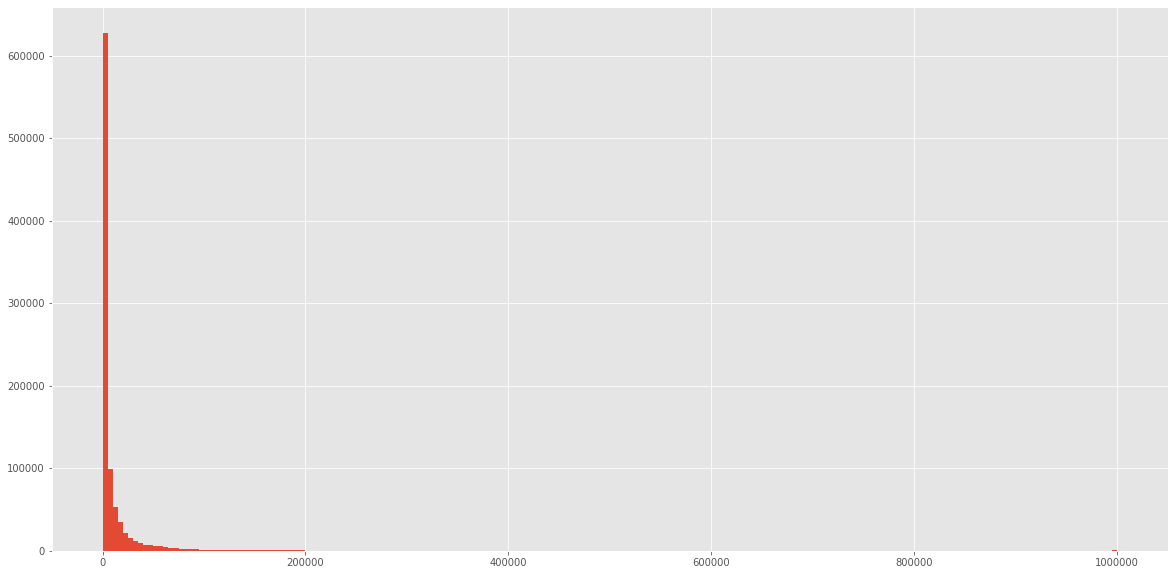

In [45]:
data['metric'].clip(lower = 0 ,upper = 1e6).hist(bins=200)

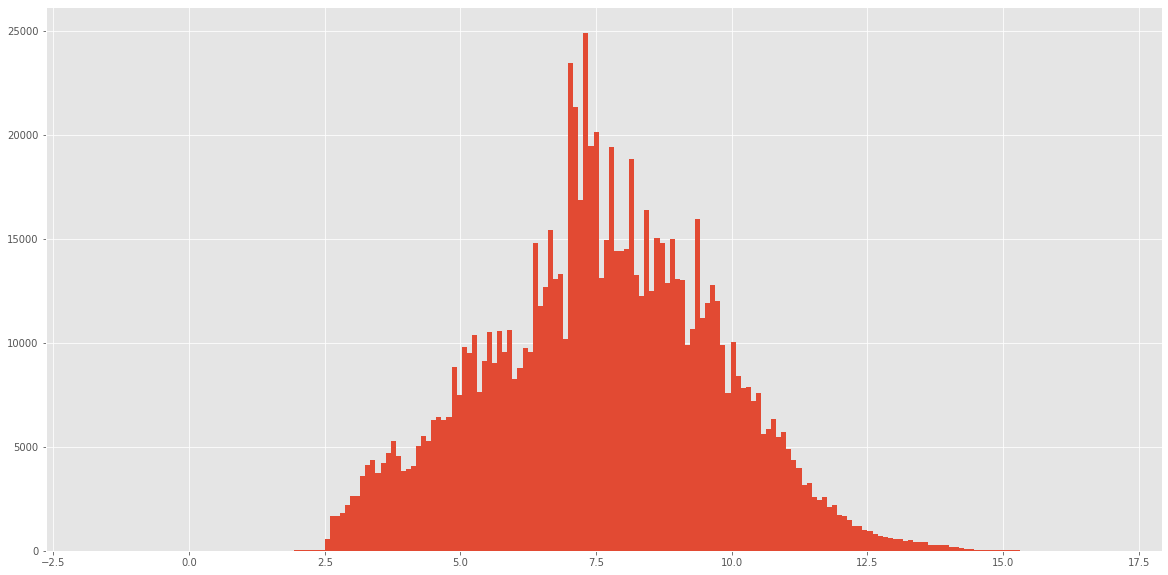

In [46]:
data['metric'].apply(np.log).hist(bins=200)

## Оценка доверительных интервалов

Варианты: 
1. T-test
1. U-test
1. Log
1. Bootstrap


Полезные ссылки:
*   https://pypi.org/project/bootstrapped/
*   https://medium.com/statistics-experiments/




###Наивное разбиение на 2 группы

In [12]:
def split_on_groups(df,size):
    """ Create samples for a/b test"""
    shuffle_data = df.sample(size*2)
    shuffle_data['test_group'] = 0
    shuffle_data.iloc[shuffle_data.shape[0]//2:,2] = 1
    return shuffle_data


shuffle_data = split_on_groups(population,population.shape[0]//2)
shuffle_data.tail()

,id,groups,test_group
554841,4M1K02,group_5,1
1153569,4XSE37,group_0,1
564347,4M8USR,group_0,1
458276,4IRKC2,group_2,1
1192443,4YE9C2,group_1,1


In [13]:
def create_data(df_data,df_sample):
  """ Select historical data conections by a/b groups """
  return (df_data.set_index('id')
                 .join(df_sample.set_index('id'),
                       how = 'inner')
                )

aa_test_data = create_data(data,shuffle_data)
aa_test_data.head()

,metric,time,groups,test_group
id,,,,
100JR,"1,174.70",2019-06-19 16:01:17.325,group_3,0
100JR,"1,210.40",2019-06-20 14:26:53.091,group_3,0
100JR,"1,154.50",2019-06-21 16:22:57.905,group_3,0
100JR,"3,437.50",2019-06-21 16:24:22.819,group_3,0
100JR,"1,482.90",2019-06-22 18:35:13.660,group_3,0


### А-А тест на истории

In [14]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

def create_bootstrap_data(df:pd.DataFrame,index)->pd.DataFrame:
    """ 
    Calculate values and ci for a-b groups  
    :param df: 1 groups must have column "metric" 
    :return: 1 row with columns 
                        'value', 
                        'lower_bound', 
                        'upper_bound'
    """
    results = bs.bootstrap(values=df['metric'].values,
                           stat_func=bs_stats.sum,
                           num_iterations=1000)
    
    return pd.DataFrame([[results.value,
                          results.lower_bound,
                          results.upper_bound 
                          ]],
                        columns=('value', 
                                 'lower_bound', 
                                 'upper_bound'),
                        index = index 
                        ) 

Даже через год тесты все еще прокрашиваются


In [15]:
pd.concat([create_bootstrap_data(data,[name])
                for name,data in aa_test_data.groupby('test_group')],
            )

,value,lower_bound,upper_bound
0,"8,395,479,468.86","8,241,246,465.67","8,532,238,603.07"
1,"8,052,178,178.24","7,899,127,026.89","8,179,140,171.44"


### A-A тест окном

In [16]:
def create_index(idx1, idx2)->pd.MultiIndex:
  """ wrapper for MultiIndex"""
  tuples_for_index = [(idx1,idx2),]
  return  MultiIndex.from_tuples(tuples_for_index)



def calculate_historical_ci(df:pd.DataFrame)->pd.DataFrame:
  """
  calculate metrics in window to see dinamic changes ci
  :param df: must have columns 
                  "time"        - timestamp of operation
                  "test_group"  - group marker
                  "metric"      - value of operation
  :return: metric value and ci for all groups in a-b testing
  for different timestamps
  """
  aa_test_data_history = df.set_index('time').sort_index()
  min_date = min(aa_test_data_history.index)
  max_date = max(aa_test_data_history.index)
  all_dates = pd.date_range(min_date, max_date, freq='10D')
  
  out_put = [
             create_bootstrap_data(
      df = data,
      index = create_index(name,idate))
            for idate in reversed(all_dates[1:])
              for name, data in (aa_test_data_history
                                 .loc[:idate]
                                 .groupby('test_group')
                                 )
              ] 

  return pd.concat(out_put)


hist_boot_data_cum = calculate_historical_ci(aa_test_data)

In [17]:
hist_boot_data_cum.head()

,,value,lower_bound,upper_bound
0,2020-06-12 01:13:09.761,"8,287,377,367.61","8,141,102,088.37","8,428,042,711.91"
1,2020-06-12 01:13:09.761,"7,923,379,877.36","7,775,660,168.00","8,062,858,011.40"
0,2020-06-02 01:13:09.761,"8,049,475,047.57","7,927,541,599.40","8,197,390,816.31"
1,2020-06-02 01:13:09.761,"7,698,237,570.38","7,553,773,333.37","7,835,796,274.32"
0,2020-05-23 01:13:09.761,"7,868,002,679.90","7,715,120,505.96","8,013,079,232.57"


In [18]:
def plot(df:pd.DataFrame):
    """
    Plot historical ci
     :param df: must have columns 
                  "time"        - timestamp of operation
                  "metric"      - value of operation
                  "lower_bound"
                  "upper_bound" 

    """
    plt.style.use('ggplot')
    plt.rcParams.update({'font.size': 10})
    for label, df_group in df.groupby(level=0):
        df_group  = df_group.droplevel(0)
        ax = df_group['value'].plot(label=f'{label}')
        ax.fill_between(df_group.index,
                        df_group['lower_bound'],
                        df_group['upper_bound'], alpha=.1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
               borderaxespad=0.)
    plt.show()


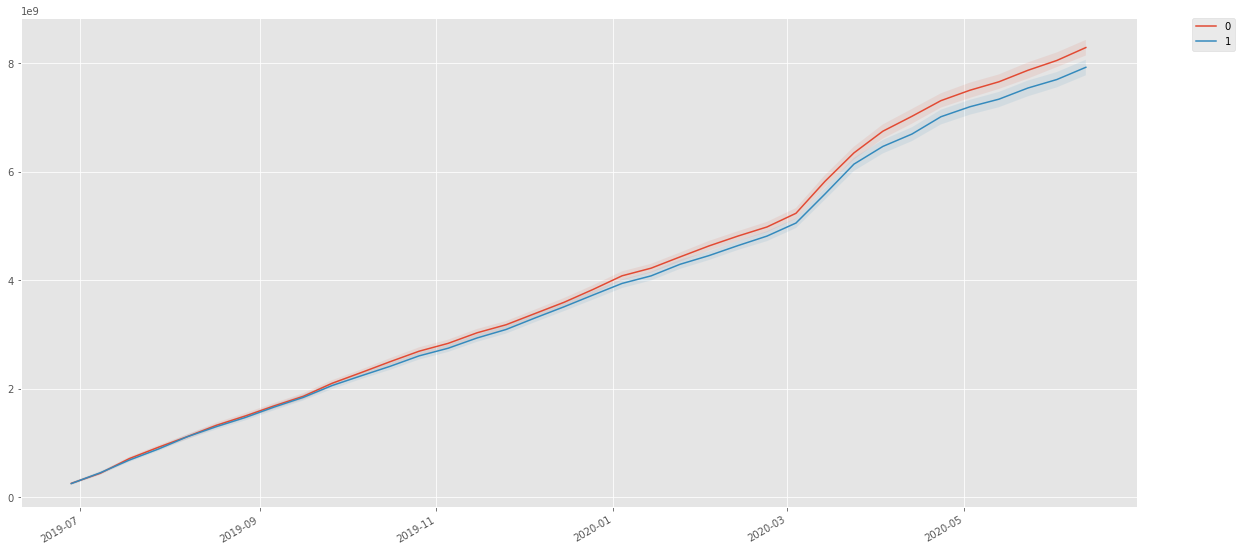

In [50]:
plot(hist_boot_data_cum)

In [20]:
def calculate_historical_ci(df):
    """
    calculate metrics in window to see dinamic changes ci
    :param df: must have columns 
                    "time"        - timestamp of operation
                    "test_group"  - group marker
                    "metric"      - value of operation
    :return: metric value average per day and ci for all groups in a-b testing
    for different timestamps
    """
    aa_test_data_history = df.set_index('time').sort_index()
    min_date = min(aa_test_data_history.index)
    max_date = max(aa_test_data_history.index)
    multi_ind = pd.date_range(min_date, max_date, freq='10D')
    return pd.concat(
      [create_bootstrap_data(df = data,
                            index = MultiIndex.from_tuples([(name,idate),]))
                            # Allowed us compere different time frame
                            /(idate-min_date).days 
        for idate in reversed(multi_ind[1:])
          for name, data in (aa_test_data_history
                             .loc[:idate]
                             .groupby('test_group'))
          ] 
          )




In [21]:
hist_boot_data = calculate_historical_ci(aa_test_data)

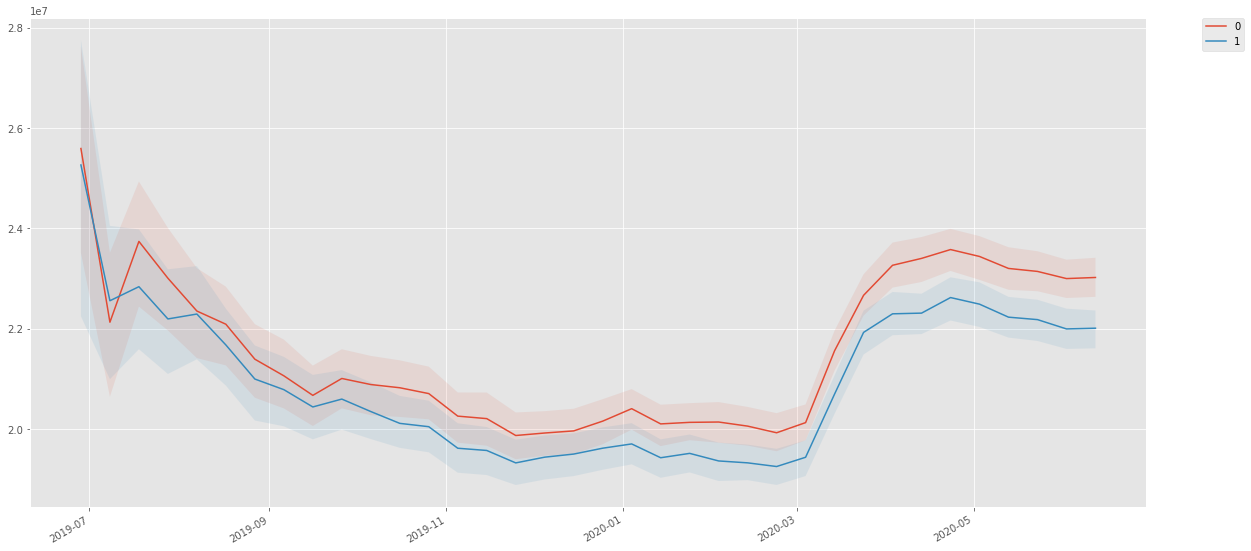

In [51]:
plot(hist_boot_data)

## Генерация меньшей группы

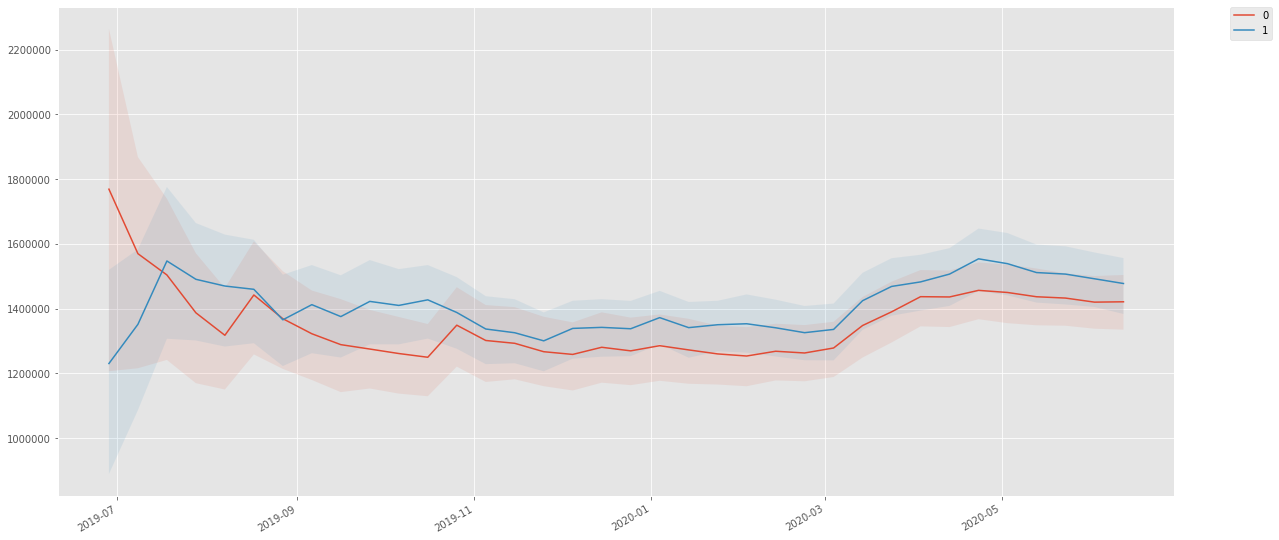

In [52]:
group_size = 60_000
small_shuffle_data = split_on_groups(population,group_size)
smal_aa_test_data = create_data(data,small_shuffle_data)
plot(calculate_historical_ci(smal_aa_test_data))


## Стратификация 

In [24]:
def generate_strat_test_groups(df:pd.DataFrame,
                               groups_size=(60_000, 60_000)):
        """ 
        create random stratified group
        :param df: must have columns 
                        "groups" - param for stratification  
        :return: df with new column "test_group"

        Step 1

          strata 1 
                    group - 1
                    group - 2

          strata 2                   
                    group - 1
                    group - 2

          strata 3
                    group - 1
                    group - 2     

        Step 2

        group - 1 , strata 1
        group - 1 , strata 2
        group - 1 , strata 3
        group - 2 , strata 1
        group - 2 , strata 2
        group - 2 , strata 3




        """
        data_list = []
        for strata,df_strata in df.groupby('groups'):
            starta_ratio = df_strata.shape[0] / df.shape[0]
            groups_size_t = [int(i*starta_ratio)  for i in groups_size]
            index = np.hstack([np.ones(g) * i 
                               for i, g in enumerate(groups_size_t)])
            group = pd.DataFrame(index, columns=['test_group'])
            df_temp = df_strata.sample(sum(groups_size_t))
            strata_dt = pd.concat([df_temp.reset_index(drop=True), group], 
                                  axis=1)
            data_list.append(strata_dt)

        return pd.concat(data_list, axis=0)

small_group = generate_strat_test_groups(population,(60_000,60_000))
small_group = create_data(data,small_group)

In [25]:
hist_boot_data_small = calculate_historical_ci(small_group)

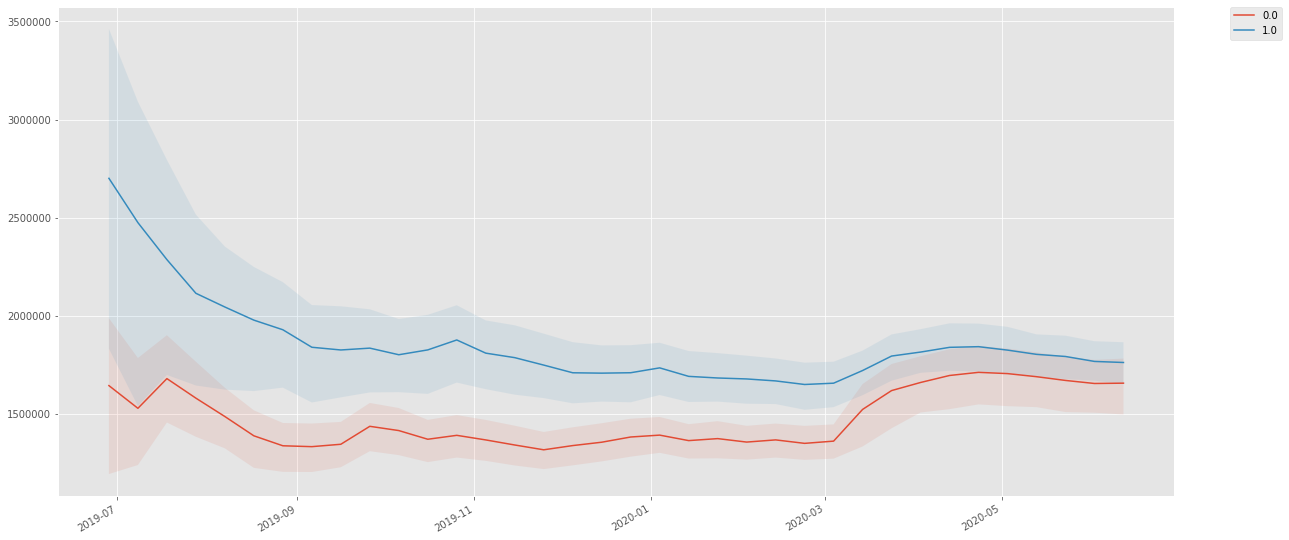

In [53]:
plot(hist_boot_data_small)

## Подгон групп

Полезные ссылки:
* https://www.tripadvisor.com/engineering/reducing-a-b-test-measurement-variance-by-30/
* https://engineering.nordeus.com/perfecting-a-b-testing/


In [27]:
split_date = data['time'].min()  + (data['time'].max() - data['time'].min())*2/3
train_data = data[data['time'] < split_date]
test_data = data[data['time'] > split_date]


In [28]:
many_groups = [generate_strat_test_groups(population,(60_000,60_000)) 
              for i in range(40)]
for df in many_groups[:3]:
    print(df.head())

       id   groups  test_group
0  4Y3YSM  group_0        0.00
1  4MIIW7  group_0        0.00
2  49LOUH  group_0        0.00
3  4UI6J2  group_0        0.00
4  50XYHM  group_0        0.00
       id   groups  test_group
0  4MBXLM  group_0        0.00
1   5LAIH  group_0        0.00
2  4YMMF2  group_0        0.00
3  4QKRYW  group_0        0.00
4  50N9EM  group_0        0.00
       id   groups  test_group
0   BGGIC  group_0        0.00
1  4REXBC  group_0        0.00
2  4QKM07  group_0        0.00
3  4M33HM  group_0        0.00
4  4UOELM  group_0        0.00


In [29]:
many_aa_test = [create_data(train_data,group
                            ) for group in many_groups]
for df in many_aa_test[:3]:
    print(df.head())

         metric                    time   groups  test_group
id                                                          
1073M  2,728.93 2019-07-13 14:10:56.313  group_3        0.00
1073M  2,675.53 2019-07-23 01:37:45.958  group_3        0.00
1073M 60,973.02 2019-08-10 01:21:47.694  group_3        0.00
1073M  9,978.76 2019-09-21 22:44:24.163  group_3        0.00
1073M  5,960.51 2019-12-07 14:57:10.112  group_3        0.00
          metric                    time   groups  test_group
id                                                           
102LH 174,171.04 2019-08-27 01:18:15.644  group_6        1.00
103X2      51.44 2019-06-20 15:27:06.261  group_5        0.00
103X2     151.54 2019-06-22 02:10:26.384  group_5        0.00
103X2      71.43 2019-06-28 12:15:07.786  group_5        0.00
103X2     134.33 2019-07-05 14:40:28.781  group_5        0.00
         metric                    time   groups  test_group
id                                                          
103FC 13,252.03 2

In [54]:
many_aa_test_t = [calculate_historical_ci(aa) for aa in many_aa_test]
for df in many_aa_test_t[:3]:
    print(df.head())

                                    value  lower_bound  upper_bound
0.00 2020-02-13 01:15:43.839 1,481,095.81 1,353,675.31 1,594,606.79
1.00 2020-02-13 01:15:43.839 1,426,445.82 1,337,062.78 1,513,336.39
0.00 2020-02-03 01:15:43.839 1,498,383.46 1,369,278.21 1,623,990.62
1.00 2020-02-03 01:15:43.839 1,439,064.91 1,345,192.91 1,526,932.43
0.00 2020-01-24 01:15:43.839 1,504,362.02 1,367,274.99 1,623,410.14
                                    value  lower_bound  upper_bound
0.00 2020-02-13 01:30:05.700 1,396,543.24 1,309,221.72 1,478,101.32
1.00 2020-02-13 01:30:05.700 1,326,581.94 1,226,552.93 1,426,753.96
0.00 2020-02-03 01:30:05.700 1,385,022.24 1,296,683.65 1,468,896.10
1.00 2020-02-03 01:30:05.700 1,328,341.41 1,217,572.97 1,427,269.32
0.00 2020-01-24 01:30:05.700 1,395,484.76 1,302,408.78 1,480,851.86
                                    value  lower_bound  upper_bound
0.00 2020-02-13 01:15:43.839 1,374,156.40 1,290,027.20 1,452,775.54
1.00 2020-02-13 01:15:43.839 1,334,011.03 1,226,

In [55]:
example = many_aa_test_t[0]
abs(example.loc[0,'value'] - example.loc[1,'value'])

2020-02-13 01:15:43.839    54,649.99
2020-02-03 01:15:43.839    59,318.55
2020-01-24 01:15:43.839    51,931.59
2020-01-14 01:15:43.839    67,124.45
2020-01-04 01:15:43.839    51,286.99
2019-12-25 01:15:43.839    20,214.89
2019-12-15 01:15:43.839    68,644.87
2019-12-05 01:15:43.839    60,118.28
2019-11-25 01:15:43.839    82,066.32
2019-11-15 01:15:43.839   109,454.64
2019-11-05 01:15:43.839   119,428.36
2019-10-26 01:15:43.839   164,822.32
2019-10-16 01:15:43.839   162,033.03
2019-10-06 01:15:43.839   130,377.98
2019-09-26 01:15:43.839   137,530.62
2019-09-16 01:15:43.839    47,553.67
2019-09-06 01:15:43.839    25,170.18
2019-08-27 01:15:43.839   102,812.22
2019-08-17 01:15:43.839   132,239.45
2019-08-07 01:15:43.839    59,466.41
2019-07-28 01:15:43.839   125,766.61
2019-07-18 01:15:43.839   238,782.35
2019-07-08 01:15:43.839   179,486.91
2019-06-28 01:15:43.839   237,611.34
Name: value, dtype: float64

In [56]:
abs(example.loc[0,'value'] - example.loc[1,'value']).ewm(alpha=0.3).mean()

2020-02-13 01:15:43.839    54,649.99
2020-02-03 01:15:43.839    57,396.20
2020-01-24 01:15:43.839    54,900.94
2020-01-14 01:15:43.839    59,726.65
2020-01-04 01:15:43.839    56,683.25
2019-12-25 01:15:43.839    44,283.98
2019-12-15 01:15:43.839    52,248.13
2019-12-05 01:15:43.839    54,753.61
2019-11-25 01:15:43.839    63,291.97
2019-11-15 01:15:43.839    77,543.34
2019-11-05 01:15:43.839    90,362.32
2019-10-26 01:15:43.839   113,013.84
2019-10-16 01:15:43.839   127,863.48
2019-10-06 01:15:43.839   128,622.98
2019-09-26 01:15:43.839   131,308.02
2019-09-16 01:15:43.839   106,097.93
2019-09-06 01:15:43.839    81,763.00
2019-08-27 01:15:43.839    88,088.06
2019-08-17 01:15:43.839   101,348.59
2019-08-07 01:15:43.839    88,773.90
2019-07-28 01:15:43.839    99,877.92
2019-07-18 01:15:43.839   141,565.55
2019-07-08 01:15:43.839   152,945.07
2019-06-28 01:15:43.839   178,349.82
Name: value, dtype: float64

In [57]:
many_aa_test_ewm = [abs(aa.loc[0,'value'] - aa.loc[1,'value']).ewm(alpha=0.1)       
                 for aa in many_aa_test_t ]

In [58]:
best_aa_index = np.argmin([aa.mean()[-1] for aa in many_aa_test_ewm])

In [59]:
best_aa = calculate_historical_ci(create_data(test_data, many_groups[best_aa_index]))

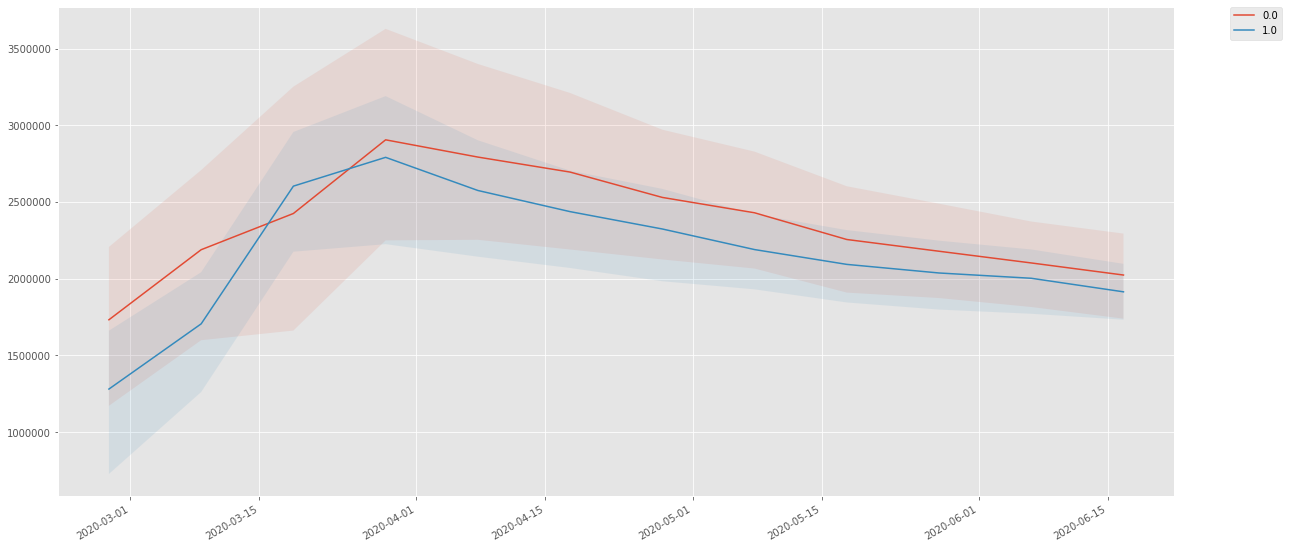

In [60]:
plot(best_aa)

## Сравнение групп

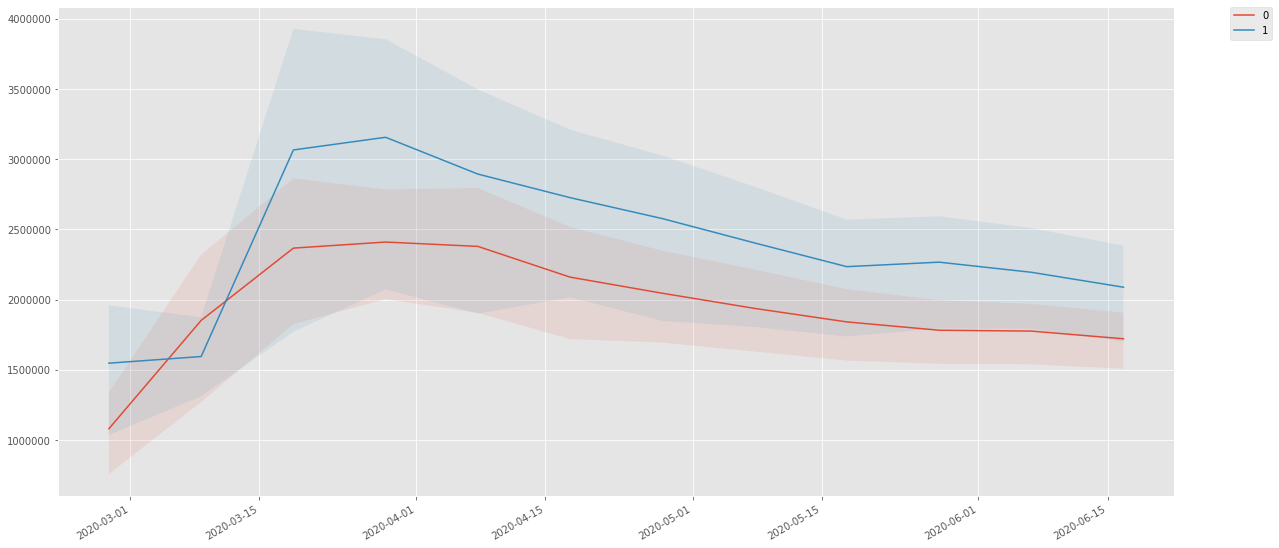

In [61]:
group_size = 60_000
с_small_shuffle_data = split_on_groups(population,group_size)
с_smal_aa_test_data = create_data(test_data,с_small_shuffle_data)
plot(calculate_historical_ci(с_smal_aa_test_data))

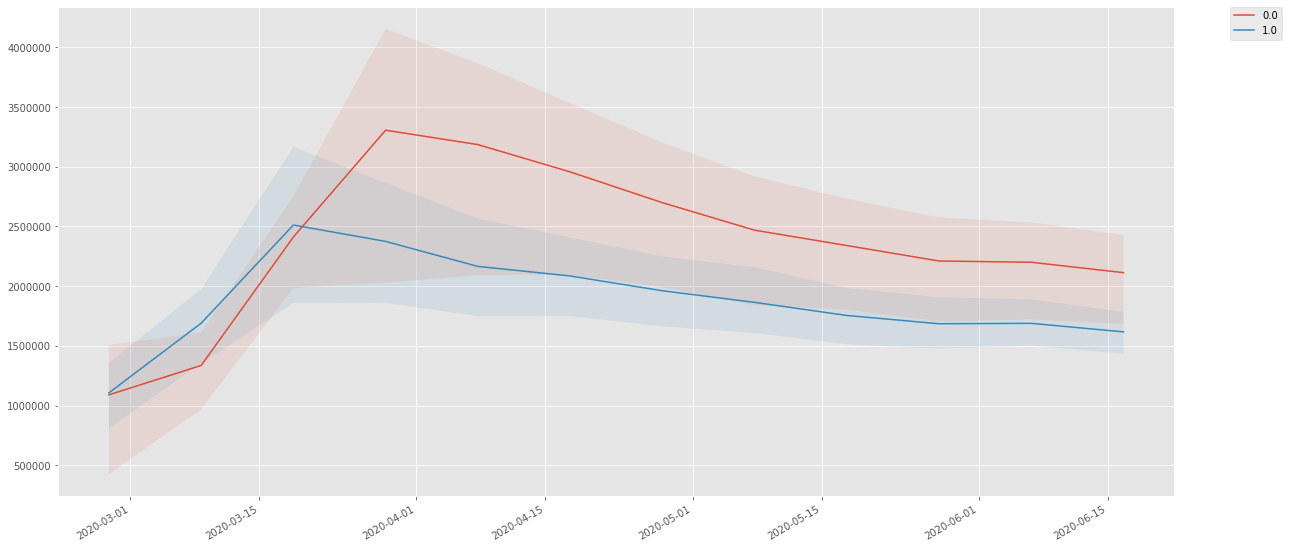

In [62]:
с_small_group = generate_strat_test_groups(population,(group_size,group_size))
с_smal_aa_test_data = create_data(test_data,с_small_group)
plot(calculate_historical_ci(с_smal_aa_test_data))

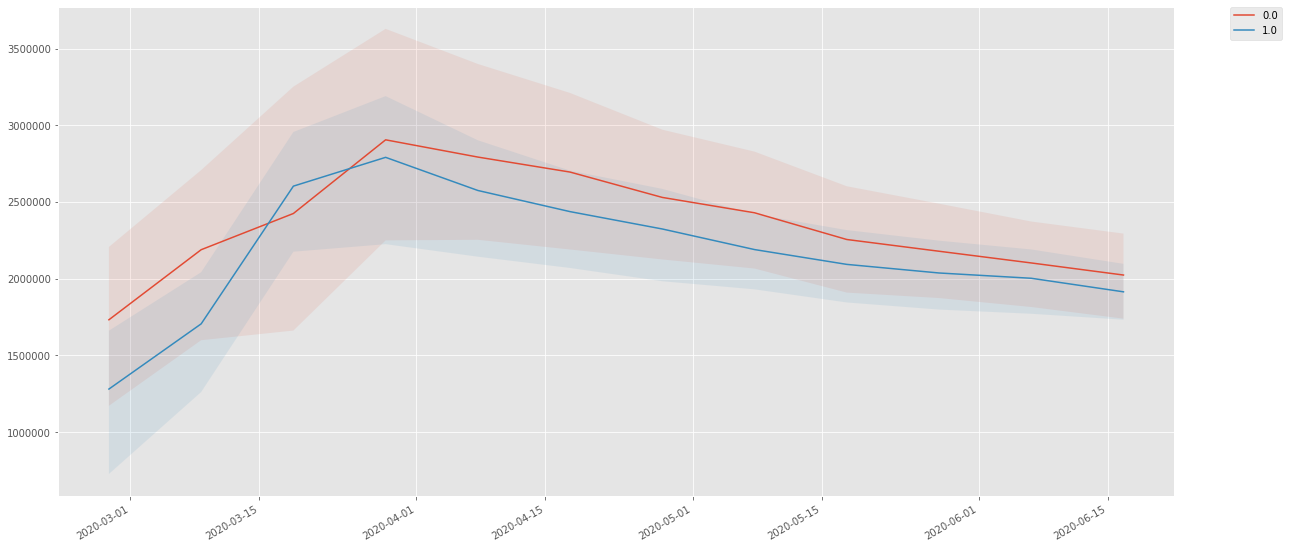

In [63]:
plot(best_aa)

In [64]:
best_aa.tail(2)

,,value,lower_bound,upper_bound
0.00,2020-02-27 17:12:40.940,"1,731,245.33","1,170,329.93","2,205,973.57"
1.00,2020-02-27 17:12:40.940,"1,279,450.46","725,905.74","1,659,857.82"
